# Deep Convolutional Generative Adversarial Network

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://tensorflow.org/alpha/tutorials/generative/images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://tensorflow.org/alpha/tutorials/generative/images/gan2.png)

This notebook demonstrate this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, we recommend MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Import TensorFlow and other libraries

In [1]:
# To generate GIFs
!pip -q install imageio

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip -q install tensorflow-gpu==1.13.1
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

### The Discriminator

The discriminator is a CNN-based image classifier.

In [5]:
class DCGAN:
  def generator(self, x):
    with tf.variable_scope("generator"):
      out = tf.layers.dense(inputs=x, units=7 * 7 * 256, use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)

      out = tf.reshape(out, shape=(-1, 7, 7, 256))

      out = tf.layers.conv2d_transpose(inputs=out, filters=128, kernel_size=5, strides=1, padding='same', use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)

      out = tf.layers.conv2d_transpose(inputs=out, filters=64, kernel_size=5, strides=2, padding='same', use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)

      out = tf.layers.conv2d_transpose(inputs=out, filters=1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')

    return out

  def discriminator(self, x):
    with tf.variable_scope("discriminator"):
      out = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, padding='same')
      out = tf.nn.leaky_relu(out)
      out = tf.layers.dropout(inputs=out, rate=0.3)

      out = tf.layers.conv2d(inputs=out, filters=128, kernel_size=5, strides=2, padding='same')
      out = tf.nn.leaky_relu(out)
      out = tf.layers.dropout(inputs=out, rate=0.3)

      out = tf.layers.flatten(inputs=out)
      out = tf.layers.dense(inputs=out, units=1)

    return out


## Define the training loop

In [6]:
epochs = 5
batch_size = 100
noise_dim=100
num_examples_to_generate=16

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [7]:
model = DCGAN()

with tf.variable_scope("dcgan", reuse=False):
  noise = tf.placeholder(shape=(None, noise_dim), dtype=tf.float32)
  generated_images = model.generator(x=noise)
  fake_output = model.discriminator(x=generated_images)

with tf.variable_scope("dcgan", reuse=True):
  images = tf.placeholder(shape=(None, 28, 28, 1), dtype=tf.float32)
  real_output = model.discriminator(x=images)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the disciminator's predictions on real images to an array of 1s, and the disciminator's predictions on fake (generated) images to an array of 0s.

In [9]:
real_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_output), logits=real_output)
fake_loss = tf.losses.sigmoid_cross_entropy(tf.zeros_like(fake_output), logits=fake_output)
disc_loss = real_loss + fake_loss

Instructions for updating:
Use tf.cast instead.


### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the disciminators decisions on the generated images to an array of 1s.

In [10]:
gen_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_output), logits=fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [11]:
optimizer = tf.train.AdamOptimizer(1e-4)

disc_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="dcgan/discriminator")
disc_bn = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="dcgan/discriminator")#Updated: No longer required

gen_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="dcgan/generator")
gen_bn = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="dcgan/generator")#Updated: No longer required

print(gen_var)
print(disc_var)

[<tf.Variable 'dcgan/generator/dense/kernel:0' shape=(100, 12544) dtype=float32_ref>, <tf.Variable 'dcgan/generator/batch_normalization/gamma:0' shape=(12544,) dtype=float32_ref>, <tf.Variable 'dcgan/generator/batch_normalization/beta:0' shape=(12544,) dtype=float32_ref>, <tf.Variable 'dcgan/generator/conv2d_transpose/kernel:0' shape=(5, 5, 128, 256) dtype=float32_ref>, <tf.Variable 'dcgan/generator/batch_normalization_1/gamma:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'dcgan/generator/batch_normalization_1/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'dcgan/generator/conv2d_transpose_1/kernel:0' shape=(5, 5, 64, 128) dtype=float32_ref>, <tf.Variable 'dcgan/generator/batch_normalization_2/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'dcgan/generator/batch_normalization_2/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'dcgan/generator/conv2d_transpose_2/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>]
[<tf.Variable 'dcgan/discriminator/conv2d/kernel:0' sha

In [12]:
# with tf.control_dependencies(disc_bn):
disc_update = optimizer.minimize(disc_loss, var_list=disc_var)

# with tf.control_dependencies(gen_bn):
gen_update = optimizer.minimize(gen_loss, var_list=gen_var)

In [13]:
def generate_and_save_images(results, epoch):
  plt.figure(figsize=(4,4))
  for i in range(len(results)):
      plt.subplot(4, 4, i+1)
      plt.imshow(np.array(results[i, :, :, 0]), cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
noise_fixed = np.random.normal(size=[num_examples_to_generate, noise_dim])

In [15]:
def train(sess):
  noise_gen = sess.run(fetches=generated_images, feed_dict={noise: noise_fixed})
  generate_and_save_images(noise_gen, epoch=0)
  for epoch in range(1, epochs + 1):
    start_time = time.time()
    rand_idx = np.random.permutation(len(train_images))
    for step in range(0, len(rand_idx)-1, batch_size):
      cur_data = train_images[rand_idx[step:step+batch_size]]
      sess.run(fetches=[gen_update, disc_update], feed_dict={images: cur_data, noise: np.random.normal(size=[len(cur_data), noise_dim])})

    end_time = time.time()

    if epoch % 1 == 0:
      tst_gen_loss, tst_disc_loss = 0., 0.
      for tst_step in range(0, len(test_images)-num_examples_to_generate+1, num_examples_to_generate):
        cur_dat = test_images[tst_step: tst_step+num_examples_to_generate]
        gl, dl = sess.run(fetches=[gen_loss, disc_loss], feed_dict={images: cur_dat, noise: noise_fixed})
        tst_gen_loss += gl
        tst_disc_loss += dl

      tst_gen_loss/= len(test_images)
      tst_disc_loss /= len(test_images)

      print('Gen Loss {}, Disc Loss {} Time for epoch {} is {} sec'.format(tst_gen_loss, tst_disc_loss, epoch + 1, end_time - start_time))
      noise_gen = sess.run(fetches=generated_images, feed_dict={noise: noise_fixed})
      generate_and_save_images(noise_gen, epoch=0)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

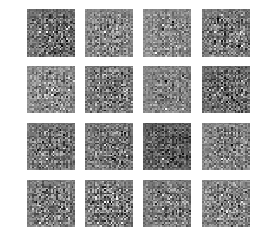

Gen Loss 0.05628366023302078, Disc Loss 0.06360300393104554 Time for epoch 2 is 8.019557237625122 sec


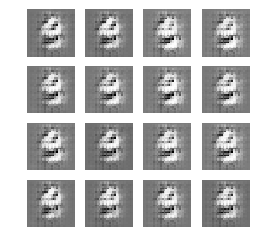

Gen Loss 0.1086014300942421, Disc Loss 0.027062289243936537 Time for epoch 3 is 8.438778162002563 sec


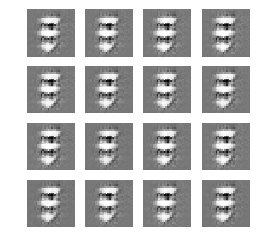

Gen Loss 0.16309064836502074, Disc Loss 0.011434340409934522 Time for epoch 4 is 7.934851408004761 sec


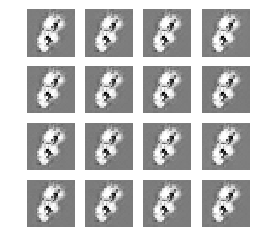

Gen Loss 0.19270953726768494, Disc Loss 0.0063152297984808686 Time for epoch 5 is 8.377741575241089 sec


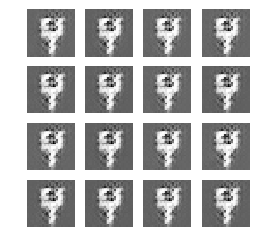

Gen Loss 0.23673748421669005, Disc Loss 0.003931548398733139 Time for epoch 6 is 8.389067888259888 sec


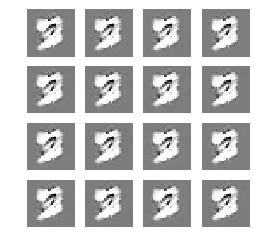

In [16]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  train(sess)

## Create a GIF


In [17]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [18]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(lite_model_path)